In [16]:
import pandas as pd
import scipy as sc
import numpy as np
import time
import sys
from sklearn.preprocessing import MultiLabelBinarizer
from data_splitter import train_test_holdout
import matplotlib.pyplot as pyplot

# addresses of the files
train_file = '../data/train.csv'
target_playlists_file = '../data/target_playlists.csv'
tracks_file = '../data/tracks.csv'

# reading of all files and renaming columns
train_data = pd.read_csv(train_file)
train_data.columns = ['playlist_id', 'track_id']

tracks_data = pd.read_csv(tracks_file)
tracks_data.columns = ['track_id', 'album_id', 'artist_id', 'duration_sec']

target_playlists = pd.read_csv(target_playlists_file)
target_playlists.columns = ['playlist_id']

# building the URM matrix
grouped_playlists = train_data.groupby('playlist_id', as_index=True).apply(lambda x: list(x['track_id']))
URM = MultiLabelBinarizer(sparse_output=True).fit_transform(grouped_playlists)
URM_csr = URM.tocsr()

# building the ICM matrix
artists = tracks_data.reindex(columns=['track_id', 'artist_id'])
artists.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
artists_list = [[a] for a in artists['artist_id']]
icm_artists = MultiLabelBinarizer(sparse_output=True).fit_transform(artists_list)
icm_artists_csr = icm_artists.tocsr()

albums = tracks_data.reindex(columns=['track_id', 'album_id'])
albums.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
albums_list = [[a] for a in albums['album_id']]
icm_albums = MultiLabelBinarizer(sparse_output=True).fit_transform(albums_list)
icm_albums_csr = icm_albums.tocsr()

durations = tracks_data.reindex(columns=['track_id', 'duration_sec'])
durations.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
durations_list = [[d] for d in durations['duration_sec']]
icm_durations = MultiLabelBinarizer(sparse_output=True).fit_transform(durations_list)
icm_durations_csr = icm_durations.tocsr()

ICM = sc.sparse.hstack((icm_albums_csr, icm_artists_csr, icm_durations_csr))
ICM_csr = ICM.tocsr()

In [2]:
# Compute_Similarity_Python

def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sc.sparse.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sc.sparse.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sc.sparse.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sc.sparse.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sc.sparse.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sc.sparse.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sc.sparse.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)



class Compute_Similarity_Python:


    def __init__(self, dataMatrix, topK=100, shrink = 0, normalize = True,
                 asymmetric_alpha = 0.5, tversky_alpha = 1.0, tversky_beta = 1.0,
                 similarity = "cosine", row_weights = None):
        """
        Computes the cosine similarity on the columns of dataMatrix
        If it is computed on URM=|users|x|items|, pass the URM as is.
        If it is computed on ICM=|items|x|features|, pass the ICM transposed.
        :param dataMatrix:
        :param topK:
        :param shrink:
        :param normalize:           If True divide the dot product by the product of the norms
        :param row_weights:         Multiply the values in each row by a specified value. Array
        :param asymmetric_alpha     Coefficient alpha for the asymmetric cosine
        :param similarity:  "cosine"        computes Cosine similarity
                            "adjusted"      computes Adjusted Cosine, removing the average of the users
                            "asymmetric"    computes Asymmetric Cosine
                            "pearson"       computes Pearson Correlation, removing the average of the items
                            "jaccard"       computes Jaccard similarity for binary interactions using Tanimoto
                            "dice"          computes Dice similarity for binary interactions
                            "tversky"       computes Tversky similarity for binary interactions
                            "tanimoto"      computes Tanimoto coefficient for binary interactions

        """
        """
        Asymmetric Cosine as described in: 
        Aiolli, F. (2013, October). Efficient top-n recommendation for very large scale binary rated datasets. In Proceedings of the 7th ACM conference on Recommender systems (pp. 273-280). ACM.
        
        """

        super(Compute_Similarity_Python, self).__init__()

        self.TopK = topK
        self.shrink = shrink
        self.normalize = normalize
        self.n_columns = dataMatrix.shape[1]
        self.n_rows = dataMatrix.shape[0]
        self.asymmetric_alpha = asymmetric_alpha
        self.tversky_alpha = tversky_alpha
        self.tversky_beta = tversky_beta

        self.dataMatrix = dataMatrix.copy()

        self.adjusted_cosine = False
        self.asymmetric_cosine = False
        self.pearson_correlation = False
        self.tanimoto_coefficient = False
        self.dice_coefficient = False
        self.tversky_coefficient = False

        if similarity == "adjusted":
            self.adjusted_cosine = True
        elif similarity == "asymmetric":
            self.asymmetric_cosine = True
        elif similarity == "pearson":
            self.pearson_correlation = True
        elif similarity == "jaccard" or similarity == "tanimoto":
            self.tanimoto_coefficient = True
            # Tanimoto has a specific kind of normalization
            self.normalize = False

        elif similarity == "dice":
            self.dice_coefficient = True
            self.normalize = False

        elif similarity == "tversky":
            self.tversky_coefficient = True
            self.normalize = False

        elif similarity == "cosine":
            pass
        else:
            raise ValueError("Cosine_Similarity: value for paramether 'mode' not recognized."
                             " Allowed values are: 'cosine', 'pearson', 'adjusted', 'asymmetric', 'jaccard', 'tanimoto',"
                             "dice, tversky."
                             " Passed value was '{}'".format(similarity))



        if self.TopK == 0:
            self.W_dense = np.zeros((self.n_columns, self.n_columns))


        self.use_row_weights = False

        if row_weights is not None:

            if dataMatrix.shape[0] != len(row_weights):
                raise ValueError("Cosine_Similarity: provided row_weights and dataMatrix have different number of rows."
                                 "Col_weights has {} columns, dataMatrix has {}.".format(len(row_weights), dataMatrix.shape[0]))

            self.use_row_weights = True
            self.row_weights = row_weights.copy()
            self.row_weights_diag = sc.diags(self.row_weights)

            self.dataMatrix_weighted = self.dataMatrix.T.dot(self.row_weights_diag).T

            
            





    def applyAdjustedCosine(self):
        """
        Remove from every data point the average for the corresponding row
        :return:
        """

        self.dataMatrix = check_matrix(self.dataMatrix, 'csr')


        interactionsPerRow = np.diff(self.dataMatrix.indptr)

        nonzeroRows = interactionsPerRow > 0
        sumPerRow = np.asarray(self.dataMatrix.sum(axis=1)).ravel()

        rowAverage = np.zeros_like(sumPerRow)
        rowAverage[nonzeroRows] = sumPerRow[nonzeroRows] / interactionsPerRow[nonzeroRows]


        # Split in blocks to avoid duplicating the whole data structure
        start_row = 0
        end_row= 0

        blockSize = 1000


        while end_row < self.n_rows:

            end_row = min(self.n_rows, end_row + blockSize)

            self.dataMatrix.data[self.dataMatrix.indptr[start_row]:self.dataMatrix.indptr[end_row]] -= \
                np.repeat(rowAverage[start_row:end_row], interactionsPerRow[start_row:end_row])

            start_row += blockSize




    def applyPearsonCorrelation(self):
        """
        Remove from every data point the average for the corresponding column
        :return:
        """

        self.dataMatrix = check_matrix(self.dataMatrix, 'csc')


        interactionsPerCol = np.diff(self.dataMatrix.indptr)

        nonzeroCols = interactionsPerCol > 0
        sumPerCol = np.asarray(self.dataMatrix.sum(axis=0)).ravel()

        colAverage = np.zeros_like(sumPerCol)
        colAverage[nonzeroCols] = sumPerCol[nonzeroCols] / interactionsPerCol[nonzeroCols]


        # Split in blocks to avoid duplicating the whole data structure
        start_col = 0
        end_col= 0

        blockSize = 1000


        while end_col < self.n_columns:

            end_col = min(self.n_columns, end_col + blockSize)

            self.dataMatrix.data[self.dataMatrix.indptr[start_col]:self.dataMatrix.indptr[end_col]] -= \
                np.repeat(colAverage[start_col:end_col], interactionsPerCol[start_col:end_col])

            start_col += blockSize


    def useOnlyBooleanInteractions(self):

        # Split in blocks to avoid duplicating the whole data structure
        start_pos = 0
        end_pos= 0

        blockSize = 1000


        while end_pos < len(self.dataMatrix.data):

            end_pos = min(len(self.dataMatrix.data), end_pos + blockSize)

            self.dataMatrix.data[start_pos:end_pos] = np.ones(end_pos-start_pos)

            start_pos += blockSize




    def compute_similarity(self, start_col=None, end_col=None, block_size = 100):
        """
        Compute the similarity for the given dataset
        :param self:
        :param start_col: column to begin with
        :param end_col: column to stop before, end_col is excluded
        :return:
        """

        values = []
        rows = []
        cols = []

        start_time = time.time()
        start_time_print_batch = start_time
        processedItems = 0


        if self.adjusted_cosine:
            self.applyAdjustedCosine()

        elif self.pearson_correlation:
            self.applyPearsonCorrelation()

        elif self.tanimoto_coefficient or self.dice_coefficient or self.tversky_coefficient:
            self.useOnlyBooleanInteractions()


        # We explore the matrix column-wise
        self.dataMatrix = check_matrix(self.dataMatrix, 'csc')


        # Compute sum of squared values to be used in normalization
        sumOfSquared = np.array(self.dataMatrix.power(2).sum(axis=0)).ravel()

        # Tanimoto does not require the square root to be applied
        if not (self.tanimoto_coefficient or self.dice_coefficient or self.tversky_coefficient):
            sumOfSquared = np.sqrt(sumOfSquared)

        if self.asymmetric_cosine:
            sumOfSquared_to_1_minus_alpha = sumOfSquared.power(2 * (1 - self.asymmetric_alpha))
            sumOfSquared_to_alpha = sumOfSquared.power(2 * self.asymmetric_alpha)


        self.dataMatrix = check_matrix(self.dataMatrix, 'csc')

        start_col_local = 0
        end_col_local = self.n_columns

        if start_col is not None and start_col>0 and start_col<self.n_columns:
            start_col_local = start_col

        if end_col is not None and end_col>start_col_local and end_col<self.n_columns:
            end_col_local = end_col




        start_col_block = start_col_local

        this_block_size = 0

        # Compute all similarities for each item using vectorization
        while start_col_block < end_col_local:

            # Add previous block size
            processedItems += this_block_size

            end_col_block = min(start_col_block + block_size, end_col_local)
            this_block_size = end_col_block-start_col_block


            if time.time() - start_time_print_batch >= 30 or end_col_block==end_col_local:
                columnPerSec = processedItems / (time.time() - start_time)

                print("Similarity column {} ( {:2.0f} % ), {:.2f} column/sec, elapsed time {:.2f} min".format(
                    processedItems, processedItems / (end_col_local - start_col_local) * 100, columnPerSec, (time.time() - start_time)/ 60))

                sys.stdout.flush()
                sys.stderr.flush()

                start_time_print_batch = time.time()


            # All data points for a given item
            item_data = self.dataMatrix[:, start_col_block:end_col_block]
            item_data = item_data.toarray().squeeze()

            if self.use_row_weights:
                #item_data = np.multiply(item_data, self.row_weights)
                #item_data = item_data.T.dot(self.row_weights_diag).T
                this_block_weights = self.dataMatrix_weighted.T.dot(item_data)

            else:
                # Compute item similarities
                this_block_weights = self.dataMatrix.T.dot(item_data)



            for col_index_in_block in range(this_block_size):

                if this_block_size == 1:
                    this_column_weights = this_block_weights
                else:
                    this_column_weights = this_block_weights[:,col_index_in_block]


                columnIndex = col_index_in_block + start_col_block
                this_column_weights[columnIndex] = 0.0

                # Apply normalization and shrinkage, ensure denominator != 0
                if self.normalize:

                    if self.asymmetric_cosine:
                        denominator = sumOfSquared_to_alpha[columnIndex] * sumOfSquared_to_1_minus_alpha + self.shrink + 1e-6
                    else:
                        denominator = sumOfSquared[columnIndex] * sumOfSquared + self.shrink + 1e-6

                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)


                # Apply the specific denominator for Tanimoto
                elif self.tanimoto_coefficient:
                    denominator = sumOfSquared[columnIndex] + sumOfSquared - this_column_weights + self.shrink + 1e-6
                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)

                elif self.dice_coefficient:
                    denominator = sumOfSquared[columnIndex] + sumOfSquared + self.shrink + 1e-6
                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)

                elif self.tversky_coefficient:
                    denominator = this_column_weights + \
                                  (sumOfSquared[columnIndex] - this_column_weights)*self.tversky_alpha + \
                                  (sumOfSquared - this_column_weights)*self.tversky_beta + self.shrink + 1e-6
                    this_column_weights = np.multiply(this_column_weights, 1 / denominator)

                # If no normalization or tanimoto is selected, apply only shrink
                elif self.shrink != 0:
                    this_column_weights = this_column_weights/self.shrink


                #this_column_weights = this_column_weights.toarray().ravel()

                if self.TopK == 0:
                    self.W_dense[:, columnIndex] = this_column_weights

                else:
                    # Sort indices and select TopK
                    # Sorting is done in three steps. Faster then plain np.argsort for higher number of items
                    # - Partition the data to extract the set of relevant items
                    # - Sort only the relevant items
                    # - Get the original item index
                    relevant_items_partition = (-this_column_weights).argpartition(self.TopK-1)[0:self.TopK]
                    relevant_items_partition_sorting = np.argsort(-this_column_weights[relevant_items_partition])
                    top_k_idx = relevant_items_partition[relevant_items_partition_sorting]

                    # Incrementally build sparse matrix, do not add zeros
                    notZerosMask = this_column_weights[top_k_idx] != 0.0
                    numNotZeros = np.sum(notZerosMask)

                    values.extend(this_column_weights[top_k_idx][notZerosMask])
                    rows.extend(top_k_idx[notZerosMask])
                    cols.extend(np.ones(numNotZeros) * columnIndex)





            start_col_block += block_size

        # End while on columns


        if self.TopK == 0:
            return self.W_dense

        else:

            W_sparse = sc.sparse.csr_matrix((values, (rows, cols)),
                                      shape=(self.n_columns, self.n_columns),
                                      dtype=np.float32)


            return W_sparse

In [3]:
def initialize_output_file():
    file = open("submission.csv", 'a')
    file.write("playlist_id,track_ids" + '\n')
    return file

# useful to print to file with the right structure
def print_to_file(playlist, tracks, file):
    file.write(str(playlist) + ',')
    index = 0
    while index < 9:
        file.write(str(tracks[index]) + ' ')
        index += 1
    file.write(str(tracks[index]) + '\n')

In [4]:
class Hybrid_recommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit_content_based(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object_content_based = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
    
        self.W_sparse_content_based = similarity_object_content_based.compute_similarity()
    
    def fit_item_based(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object_item_cf = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
    
        self.W_sparse_item_cf = similarity_object_item_cf.compute_similarity()
        print(np.shape(self.W_sparse_item_cf))
    
    
    def recommend(self, user_id, alfa, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        
        scores_content_based = user_profile.dot(self.W_sparse_content_based).toarray().ravel()
        scores_item_cf = user_profile.dot(self.W_sparse_item_cf).toarray().ravel()
        
        scores = alfa * scores_content_based + (1 - alfa) * scores_item_cf
        
        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [5]:
# Evaluator

def precision(is_relevant, relevant_items):

    #is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score



def recall(is_relevant, relevant_items):

    #is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score



def MAP(is_relevant, relevant_items):

    #is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score



def evaluate_algorithm(URM_test, recommender_object, alfa, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0

    num_eval = 0

    URM_test = sc.sparse.csr_matrix(URM_test)

    n_users = URM_test.shape[0]


    for user_id in range(n_users):

        if user_id % 10000 == 0:
            print("Evaluated user {} of {}".format(user_id, n_users))

        start_pos = URM_test.indptr[user_id]
        end_pos = URM_test.indptr[user_id+1]

        if end_pos-start_pos>0:

            relevant_items = URM_test.indices[start_pos:end_pos]
            
            # add parameter alfa befor at
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

            cumulative_precision += precision(is_relevant, relevant_items)
            cumulative_recall += recall(is_relevant, relevant_items)
            cumulative_MAP += MAP(is_relevant, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval

    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))

    result_dict = {
        "precision": cumulative_precision,
        "recall": cumulative_recall,
        "MAP": cumulative_MAP,
    }

    return result_dict

In [6]:
class Recommender_content_based(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit_content_based(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object_content_based = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
    
        self.W_sparse_content_based = similarity_object_content_based.compute_similarity()
    
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        
        scores_content_based = user_profile.dot(self.W_sparse_content_based).toarray().ravel()
        
        if exclude_seen:
            scores_content_based = self.filter_seen(user_id, scores_content_based)

        # rank items
        ranking = scores_content_based.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [7]:
class Recommender_item_based(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit_item_based(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object_item_cf = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
    
        self.W_sparse_item_cf = similarity_object_item_cf.compute_similarity()
        print(np.shape(self.W_sparse_item_cf))
    
    
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        
        scores_item_cf = user_profile.dot(self.W_sparse_item_cf).toarray().ravel()
        
        if exclude_seen:
            scores_item_cf = self.filter_seen(user_id, scores_item_cf)

        # rank items
        ranking = scores_item_cf.argsort()[::-1]
            
        return ranking[:at]
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [12]:
# Splitting the URM
URM_train, URM_test = train_test_holdout(URM_csr, train_perc = 0.8)

In [13]:
np.shape(URM_train)

(50446, 20635)

In [14]:
np.shape(URM_test)

(50446, 20635)

In [15]:
content_based_recommender = Recommender_content_based(URM_train, ICM_csr)
item_based_recommender = Recommender_item_based(URM_train)

In [56]:
# tuning for topK in item_based
topk_range = [15, 50, 200]
topk_result = []
for topk in topk_range:
    item_based_recommender.fit_item_based(shrink=20, topK=topk)
    alfa = 1 #not important
    result = evaluate_algorithm(URM_test, item_based_recommender, alfa, 10)
    topk_result.append(result["MAP"])

Similarity column 15600 ( 76 % ), 517.14 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 100 % ), 509.84 column/sec, elapsed time 0.67 min
(20635, 20635)
Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.1483, Recall = 0.1367, MAP = 0.1059
Similarity column 15400 ( 75 % ), 512.52 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 100 % ), 513.62 column/sec, elapsed time 0.67 min
(20635, 20635)
Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.1612, Recall = 0.1472, MAP = 0.1165
Similarity column 17000 ( 82 % ), 564.83 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 100 % ), 550.02 column/sec, elapsed time 0.62 min
(20635, 2

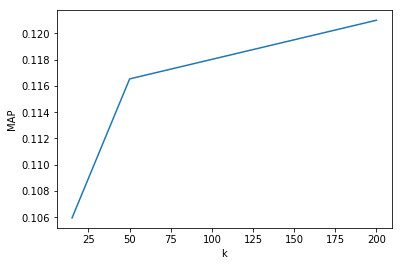

In [57]:
pyplot.plot(topk_range, topk_result)
pyplot.ylabel('MAP')
pyplot.xlabel('k')
pyplot.show()

In [52]:
# tuning shrink for item_based
item_based_recommender.fit_item_based(shrink=50, topK=50)
alfa = 0 #not important here
result = evaluate_algorithm(URM_test, item_based_recommender, alfa, 10)
shrink_result.append(result["MAP"])

Similarity column 15100 ( 73 % ), 500.64 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 100 % ), 498.61 column/sec, elapsed time 0.69 min
(20635, 20635)
Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.1611, Recall = 0.1467, MAP = 0.1164


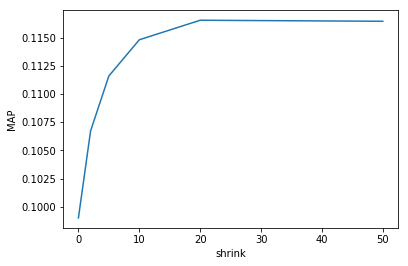

In [55]:
pyplot.plot(shrink_range, shrink_result)
pyplot.ylabel('MAP')
pyplot.xlabel('shrink')
pyplot.show()

In [ ]:
# tuning topK for content_based
topk_range = [1000]
topk_result = []
for topk in topk_range:
    content_based_recommender.fit_content_based(shrink=5, topK=topk)
    result = evaluate_algorithm(URM_test, content_based_recommender, 1, 10)
    topk_result.append(result["MAP"])

Similarity column 20600 ( 100 % ), 1159.41 column/sec, elapsed time 0.30 min
Evaluated user 0 of 50446
Evaluated user 10000 of 50446


In [ ]:
pyplot.plot(topk_range, topk_result)
pyplot.ylabel('MAP')
pyplot.xlabel('k')
pyplot.show()

In [28]:
class User_based_cf_recommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object_user_cf = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
    
        self.W_sparse_user_cf = similarity_object_user_cf.compute_similarity()
      
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        
        scores_user_cf = self.W_sparse_user_cf.dot(user_profile).toarray().ravel()
        
        if exclude_seen:
            scores_user_cf = self.filter_seen(user_id, scores_user_cf)

        # rank items
        ranking = scores_user_cf.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [29]:
#fitting and evaluating the user_based_cf
recommender = User_based_cf_recommender(URM_train, ICM_csr)
recommender.fit(topK=50, shrink=5)
evaluate_algorithm(URM_test, recommender, 0, 10)

Similarity column 15400 ( 75 % ), 512.53 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 100 % ), 512.85 column/sec, elapsed time 0.67 min
Evaluated user 0 of 50446


ValueError: dimension mismatch

In [12]:
# Fitting the hybrid recommender
recommender = Recommender(URM_csr, ICM_csr)
recommender.fit_content_based(shrink=5, topK=1000)
recommender.fit_item_based(shrink=20, topK=1000)

Similarity column 20600 ( 100 % ), 1280.43 column/sec, elapsed time 0.27 min
Similarity column 9300 ( 45 % ), 309.88 column/sec, elapsed time 0.50 min
Similarity column 18800 ( 91 % ), 311.24 column/sec, elapsed time 1.01 min
Similarity column 20600 ( 100 % ), 312.34 column/sec, elapsed time 1.10 min
(20635, 20635)


In [13]:
# execution of the recommendations for submission
file = initialize_output_file()
alfa = 0.3
for playlist in target_playlists.itertuples(index=True, name='Pandas'):
    playlist_id = getattr(playlist, "playlist_id")
    tracks = recommender.recommend(playlist_id, alfa, 10, True)
    print_to_file(playlist_id, tracks, file)
    
file.close()